In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv("data/df_post_EDA.csv", index_col=0)
df.head()

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,chapter_size,chapter_retention_rate,chapter_growth_rate,seat_popularity_rate,total_meetings,wont_renew
0,0,31,2016-04-01,33,0,0,1,0,21,7,33,32,1,37,129784,45,0,32,0.315789,1.421053,0.076923,34,0
1,2,18,2017-05-01,33,2,2,0,0,6,17,11,22,1,26,9285,1,0,34,0.718750,1.093750,0.266667,37,0
2,2,18,2018-05-01,35,1,0,0,2,6,24,19,36,1,20,7263,10,1,21,0.424242,0.636364,0.210526,38,0
3,2,18,2019-05-01,36,0,0,0,1,9,8,23,19,3,28,1860,31,2,22,0.739130,1.217391,0.263158,37,0
4,2,18,2020-05-01,33,1,0,0,3,10,13,19,47,4,30,6668,16,3,26,0.760000,1.120000,0.277778,37,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2191 entries, 0 to 2428
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_ID                 2191 non-null   int64  
 1   chapter_ID              2191 non-null   int64  
 2   relative_renewal_date   2191 non-null   object 
 3   P                       2191 non-null   int64  
 4   A                       2191 non-null   int64  
 5   L                       2191 non-null   int64  
 6   M                       2191 non-null   int64  
 7   S                       2191 non-null   int64  
 8   RGI                     2191 non-null   int64  
 9   RGO                     2191 non-null   int64  
 10  RRI                     2191 non-null   int64  
 11  RRO                     2191 non-null   int64  
 12  V                       2191 non-null   int64  
 13  1-2-1                   2191 non-null   int64  
 14  TYFCB                   2191 non-null   

### Drop & split

In [4]:
df.drop(["user_ID", "relative_renewal_date"], axis=1, inplace=True)

# Prepare data
## Feature multiplication

In [5]:
df.columns.tolist()

['chapter_ID',
 'P',
 'A',
 'L',
 'M',
 'S',
 'RGI',
 'RGO',
 'RRI',
 'RRO',
 'V',
 '1-2-1',
 'TYFCB',
 'CEU',
 'year_of_membership',
 'chapter_size',
 'chapter_retention_rate',
 'chapter_growth_rate',
 'seat_popularity_rate',
 'total_meetings',
 'wont_renew']

In [6]:
df["P_by_A"] = df["P"] / (df["A"] + 1)
df["P_by_M"] = df["P"] / (df["M"] + 1)
df["P_by_S"] = df["P"] / (df["S"] + 1)
df["P_by_total"] = df["P"] / df["total_meetings"]
df["A_by_total"] = df["A"] / df["total_meetings"]
df["M_by_total"] = df["M"] / df["total_meetings"]

df["P_tim_retention"] = df["P"] * df["chapter_retention_rate"]
df["P_tim_growth"] = df["P"] * df["chapter_growth_rate"]
df["P_tim_popularity"] = df["P"] * df["seat_popularity_rate"]
df["P_tim_V"] = df["P"] * df["V"]
df["P2_tim_V"] = df["P"]**2 * df["V"]
df["P_tim_TYFCB"] = df["P"] * df["TYFCB"]

df["year_tim_retention"] = df["year_of_membership"] * df["chapter_retention_rate"]

df["P2"] = df["P"]**2

columns_list = df.columns.tolist()
columns_list.remove("wont_renew")

columns_list+= ["wont_renew"]
df = df[columns_list]

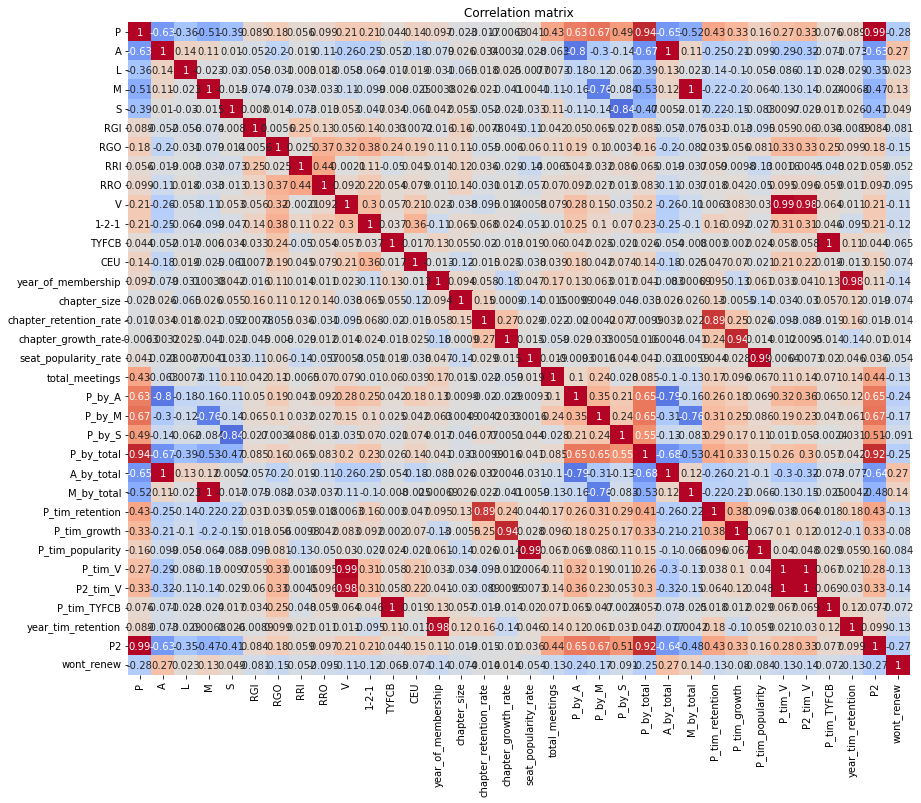

In [7]:
corr = df.iloc[:,1:].corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, cbar=False, annot=True, vmin=-1, vmax=1, center=0, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

In [8]:
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.linear_model import LogisticRegression

X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.8,
    missing_values="ignore",
    selection_method="variance",
)

X = tr.fit_transform(X)

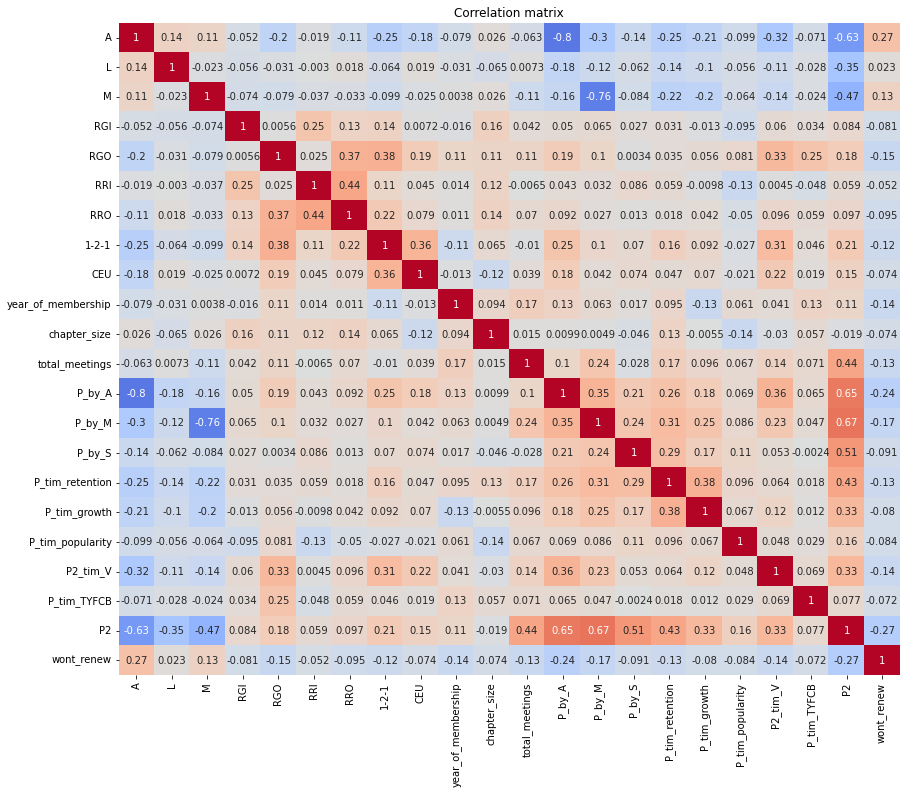

In [9]:
corr = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, cbar=False, annot=True, vmin=-1, vmax=1, center=0, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# Feature Selection

First remove highly correlated features

Then use top 4 AUC performing models:
- Logistic Regression
- Random Forest
- XGBoost
- CatBoost

to complete recursive feature selection.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

## Feature selection: Logistic Regression

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [12]:
model = LogisticRegression(max_iter=2000)
model.fit(X_resampled, y_resampled)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-27 14:18:44.903083 ROC AuC all features 0.7002436647173488


In [13]:
df_feature_importance = pd.DataFrame({'feature_importance': np.abs(model.coef_)[0],
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_logreg.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [14]:
df_results.head()

,nr_features,list_features,auc
0,21,"[A, year_of_membership, P_tim_popularity, P2, ...",0.700244


In [15]:
for nr_features in range(X_resampled.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_resampled = X_resampled[list_features]
    X_test = X_test[list_features]
    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': np.abs(model.coef_)[0],
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_logreg.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_logreg.csv")

2021-12-27 14:18:47.916312 20 features - ROC AuC 0.6998538011695907
2021-12-27 14:18:47.932324 19 features - ROC AuC 0.6996345029239768
2021-12-27 14:18:47.946333 18 features - ROC AuC 0.6991959064327485
2021-12-27 14:18:47.960321 17 features - ROC AuC 0.6990253411306044
2021-12-27 14:18:47.974338 16 features - ROC AuC 0.7005116959064328
2021-12-27 14:18:47.983421 15 features - ROC AuC 0.6986842105263158
2021-12-27 14:18:47.999066 14 features - ROC AuC 0.7010721247563353
2021-12-27 14:18:48.014693 13 features - ROC AuC 0.6974658869395711
2021-12-27 14:18:48.014693 12 features - ROC AuC 0.6977582846003898
2021-12-27 14:18:48.030306 11 features - ROC AuC 0.7005604288499026
2021-12-27 14:18:48.045943 10 features - ROC AuC 0.7020955165692008
2021-12-27 14:18:48.061571 9 features - ROC AuC 0.6960526315789475
2021-12-27 14:18:48.061571 8 features - ROC AuC 0.6938352826510721
2021-12-27 14:18:48.077185 7 features - ROC AuC 0.6839912280701755
2021-12-27 14:18:48.092823 6 features - ROC AuC 0.6

## Feature selection: Decision Tree

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [17]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-27 14:19:06.041192 ROC AuC all features 0.5474658869395712


In [18]:
df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_,
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_dt.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [19]:
for nr_features in range(X_resampled.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_resampled = X_resampled[list_features]
    X_test = X_test[list_features]
    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_,
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_dt.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_dt.csv")

2021-12-27 14:19:09.534974 20 features - ROC AuC 0.5495248538011696
2021-12-27 14:19:09.555982 19 features - ROC AuC 0.535124269005848
2021-12-27 14:19:09.577968 18 features - ROC AuC 0.5388279727095516
2021-12-27 14:19:09.597654 17 features - ROC AuC 0.5445784600389864
2021-12-27 14:19:09.613281 16 features - ROC AuC 0.5445784600389864
2021-12-27 14:19:09.628888 15 features - ROC AuC 0.5474658869395712
2021-12-27 14:19:09.662210 14 features - ROC AuC 0.5486963937621832
2021-12-27 14:19:09.683342 13 features - ROC AuC 0.5351120857699805
2021-12-27 14:19:09.703345 12 features - ROC AuC 0.558162768031189
2021-12-27 14:19:09.722350 11 features - ROC AuC 0.5811890838206627
2021-12-27 14:19:09.740356 10 features - ROC AuC 0.5890229044834308
2021-12-27 14:19:09.758360 9 features - ROC AuC 0.5626827485380117
2021-12-27 14:19:09.775362 8 features - ROC AuC 0.5589668615984406
2021-12-27 14:19:09.792366 7 features - ROC AuC 0.5342958089668616
2021-12-27 14:19:09.807369 6 features - ROC AuC 0.593

## Feature selection: Random Forest

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [21]:
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-27 14:19:16.675091 ROC AuC all features 0.6869517543859649


In [22]:
df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_,
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_rf.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [23]:
for nr_features in range(X_resampled.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_resampled = X_resampled[list_features]
    X_test = X_test[list_features]
    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_,
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_rf.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_rf.csv")

2021-12-27 14:19:18.402043 20 features - ROC AuC 0.6851486354775828
2021-12-27 14:19:18.744025 19 features - ROC AuC 0.6908625730994151
2021-12-27 14:19:19.091978 18 features - ROC AuC 0.6855263157894737
2021-12-27 14:19:19.451954 17 features - ROC AuC 0.6965155945419103
2021-12-27 14:19:19.793267 16 features - ROC AuC 0.7097831384015595
2021-12-27 14:19:20.118408 15 features - ROC AuC 0.6890229044834308
2021-12-27 14:19:20.428339 14 features - ROC AuC 0.6870857699805069
2021-12-27 14:19:20.755577 13 features - ROC AuC 0.6892543859649123
2021-12-27 14:19:21.077276 12 features - ROC AuC 0.6986598440545808
2021-12-27 14:19:21.395545 11 features - ROC AuC 0.7016812865497076
2021-12-27 14:19:21.711637 10 features - ROC AuC 0.6909600389863547
2021-12-27 14:19:22.042811 9 features - ROC AuC 0.7011574074074073
2021-12-27 14:19:22.313648 8 features - ROC AuC 0.6924585769980507
2021-12-27 14:19:22.581907 7 features - ROC AuC 0.684965886939571
2021-12-27 14:19:22.881120 6 features - ROC AuC 0.65

## Feature selection: AdaBoost


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [25]:
model = AdaBoostClassifier()
model.fit(X_resampled, y_resampled)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-27 14:19:27.029291 ROC AuC all features 0.6853679337231969


In [26]:
df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_,
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_ada.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [27]:
for nr_features in range(X_resampled.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_resampled = X_resampled[list_features]
    X_test = X_test[list_features]
    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_,
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_ada.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_ada.csv")

2021-12-27 14:19:28.460666 20 features - ROC AuC 0.6853679337231969
2021-12-27 14:19:28.585673 19 features - ROC AuC 0.6853679337231969
2021-12-27 14:19:28.730163 18 features - ROC AuC 0.6858308966861598
2021-12-27 14:19:28.870779 17 features - ROC AuC 0.6817860623781676
2021-12-27 14:19:28.998216 16 features - ROC AuC 0.6950657894736841
2021-12-27 14:19:29.123243 15 features - ROC AuC 0.6677753411306042
2021-12-27 14:19:29.253288 14 features - ROC AuC 0.6740618908382066
2021-12-27 14:19:29.379892 13 features - ROC AuC 0.6626218323586744
2021-12-27 14:19:29.501782 12 features - ROC AuC 0.6734527290448342
2021-12-27 14:19:29.608621 11 features - ROC AuC 0.6619883040935672
2021-12-27 14:19:29.726946 10 features - ROC AuC 0.6673611111111112
2021-12-27 14:19:29.842560 9 features - ROC AuC 0.6673976608187134
2021-12-27 14:19:29.959957 8 features - ROC AuC 0.6469785575048732
2021-12-27 14:19:30.060528 7 features - ROC AuC 0.6482212475633528
2021-12-27 14:19:30.154284 6 features - ROC AuC 0.6

## Feature selection: XGBoost

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [29]:
model = xgb.XGBClassifier(eval_metric="auc", n_jobs=-1, random_state=42, use_label_encoder=False)
model.fit(X_resampled, y_resampled)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-27 14:19:36.695223 ROC AuC all features 0.672733918128655


In [30]:
df_feature_importance = pd.DataFrame({'feature_importance': list(model.get_booster().get_score(importance_type="gain").values()),
                                      'feature_name': list(model.get_booster().get_score(importance_type="gain").keys())}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_xgb.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [31]:
df_feature_importance.head()

,feature_importance,feature_name
0,7.693054,P2
15,2.309029,A
9,1.840215,M
2,1.703036,P_tim_TYFCB
1,1.557145,RGO


In [32]:
for nr_features in range(X_resampled.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_resampled = X_resampled[list_features]
    X_test = X_test[list_features]
    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': list(model.get_booster().get_score(importance_type="gain").values()),
                                      'feature_name': list(model.get_booster().get_score(importance_type="gain").keys())}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_xgb.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_xgb.csv")

2021-12-27 14:19:40.279043 20 features - ROC AuC 0.6963206627680313
2021-12-27 14:19:40.451569 19 features - ROC AuC 0.6812378167641326
2021-12-27 14:19:40.654441 18 features - ROC AuC 0.684088693957115
2021-12-27 14:19:40.846877 17 features - ROC AuC 0.6773391812865497
2021-12-27 14:19:41.022116 16 features - ROC AuC 0.6850877192982456
2021-12-27 14:19:41.229551 15 features - ROC AuC 0.6747319688109161
2021-12-27 14:19:41.422820 14 features - ROC AuC 0.6813352826510721
2021-12-27 14:19:41.628908 13 features - ROC AuC 0.6900341130604288
2021-12-27 14:19:41.812819 12 features - ROC AuC 0.6746345029239766
2021-12-27 14:19:42.011143 11 features - ROC AuC 0.6730750487329434
2021-12-27 14:19:42.213900 10 features - ROC AuC 0.6727826510721249
2021-12-27 14:19:42.404546 9 features - ROC AuC 0.65682261208577
2021-12-27 14:19:42.576121 8 features - ROC AuC 0.6588206627680312
2021-12-27 14:19:42.758531 7 features - ROC AuC 0.6567495126705652
2021-12-27 14:19:42.910793 6 features - ROC AuC 0.6283

## Feature selection: CatBoost

In [34]:
X = df.drop(["wont_renew"], axis=1).copy()
y = df["wont_renew"].copy()

tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.8,
    missing_values="ignore",
    selection_method="variance"
)

X = tr.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

In [35]:
from catboost import Pool

model = CatBoostClassifier(early_stopping_rounds=20, eval_metric="AUC")

pool_train = Pool(X_train, y_train, cat_features=["chapter_ID"])
pool_test = Pool(X_test, y_test, cat_features=["chapter_ID"])

model.fit(pool_train, verbose=0)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-27 14:21:31.117812 ROC AuC all features 0.7156920077972709


In [36]:
df_feature_importance = pd.DataFrame({'feature_importance': model.get_feature_importance(pool_train),
                                      'feature_name': X_train.columns}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_catboost.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [37]:
df_feature_importance.head()

,feature_importance,feature_name
18,8.740724,P_tim_popularity
16,7.756356,P_tim_retention
20,6.732621,P_tim_TYFCB
4,6.415765,RGI
8,6.407379,1-2-1


In [38]:
for nr_features in range(X_train.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_train = X_train[list_features]
    X_test = X_test[list_features]
    
    if "chapter_ID" in list_features:
        pool_train = Pool(X_train, y_train, cat_features=["chapter_ID"])
        pool_test = Pool(X_test, y_test, cat_features=["chapter_ID"])
    else:
        pool_train = Pool(X_train, y_train)
        pool_test = Pool(X_test, y_test)
    
    model.fit(pool_train, verbose=0)

    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': model.get_feature_importance(pool_train),
                                      'feature_name': X_train.columns}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_catboost.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_catboost.csv")

2021-12-27 14:21:55.666116 21 features - ROC AuC 0.7179337231968812
2021-12-27 14:22:20.819768 20 features - ROC AuC 0.6984649122807016
2021-12-27 14:22:45.220568 19 features - ROC AuC 0.7014132553606237
2021-12-27 14:23:09.846597 18 features - ROC AuC 0.7108430799220274
2021-12-27 14:23:34.227822 17 features - ROC AuC 0.6938109161793372
2021-12-27 14:23:58.166866 16 features - ROC AuC 0.6994639376218323
2021-12-27 14:24:22.389576 15 features - ROC AuC 0.706335282651072
2021-12-27 14:24:51.730494 14 features - ROC AuC 0.6985136452241714
2021-12-27 14:25:23.282194 13 features - ROC AuC 0.6980994152046783
2021-12-27 14:25:54.711655 12 features - ROC AuC 0.6916423001949319
2021-12-27 14:26:22.017037 11 features - ROC AuC 0.6763888888888888
2021-12-27 14:26:52.835711 10 features - ROC AuC 0.668421052631579
2021-12-27 14:27:20.092397 9 features - ROC AuC 0.6709307992202729
2021-12-27 14:27:46.658250 8 features - ROC AuC 0.6772417153996102
2021-12-27 14:28:11.312348 7 features - ROC AuC 0.67

### Get results

In [51]:
df_results_logreg = pd.read_csv("feature_selection_results_logreg.csv", index_col=0)
df_results_dt = pd.read_csv("feature_selection_results_dt.csv", index_col=0)
df_results_rf = pd.read_csv("feature_selection_results_rf.csv", index_col=0)
df_results_ada = pd.read_csv("feature_selection_results_ada.csv", index_col=0)
df_results_xgb = pd.read_csv("feature_selection_results_xgb.csv", index_col=0)
df_results_cat = pd.read_csv("feature_selection_results_catboost.csv", index_col=0)
df_results_rf.head()

,nr_features,list_features,auc
0,21,"['P_tim_TYFCB', 'P_tim_retention', 'P_tim_popu...",0.686952
1,20,"[['P_tim_TYFCB', 'P_tim_retention', 'P_tim_pop...",0.685149
2,19,"[['P_tim_TYFCB', 'P_tim_retention', 'P_tim_pop...",0.690863
3,18,"[['P_tim_TYFCB', 'P_tim_retention', 'P_tim_pop...",0.685526
4,17,"[['P_tim_TYFCB', 'P_tim_retention', 'P_tim_pop...",0.696516


In [52]:
df_results_logreg.drop(["list_features"], axis=1, inplace=True)
df_results_dt.drop(["list_features"], axis=1, inplace=True)
df_results_rf.drop(["list_features"], axis=1, inplace=True)
df_results_ada.drop(["list_features"], axis=1, inplace=True)
df_results_xgb.drop(["list_features"], axis=1, inplace=True)
df_results_cat.drop(["list_features"], axis=1, inplace=True)

df_results_logreg.rename({"auc": "auc_logreg"}, axis=1, inplace=True)
df_results_dt.rename({"auc": "auc_dt"}, axis=1, inplace=True)
df_results_rf.rename({"auc": "auc_rf"}, axis=1, inplace=True)
df_results_ada.rename({"auc": "auc_ada"}, axis=1, inplace=True)
df_results_xgb.rename({"auc": "auc_xgb"}, axis=1, inplace=True)
df_results_cat.rename({"auc": "auc_catboost"}, axis=1, inplace=True)

In [53]:
df_results = df_results_cat.merge(df_results_logreg, how="left", on="nr_features")
df_results = df_results.merge(df_results_dt, how="left", on="nr_features")
df_results = df_results.merge(df_results_rf, how="left", on="nr_features")
df_results = df_results.merge(df_results_ada, how="left", on="nr_features")
df_results = df_results.merge(df_results_xgb, how="left", on="nr_features")

df_results.head()

,nr_features,auc_catboost,auc_logreg,auc_dt,auc_rf,auc_ada,auc_xgb
0,22,0.715692,NaN,NaN,NaN,NaN,NaN
1,21,0.717934,0.700244,0.547466,0.686952,0.685368,0.672734
2,20,0.698465,0.699854,0.549525,0.685149,0.685368,0.696321
3,19,0.701413,0.699635,0.535124,0.690863,0.685368,0.681238
4,18,0.710843,0.699196,0.538828,0.685526,0.685831,0.684089


In [54]:
df_results["auc_mean"] = df_results.iloc[:,1:].mean(axis=1)

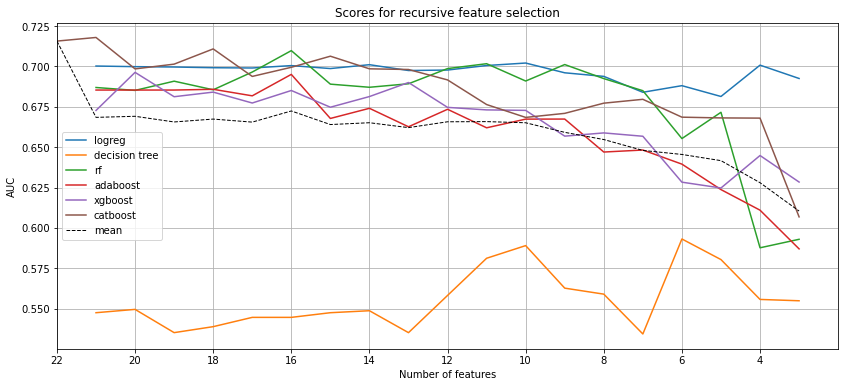

In [55]:
plt.figure(figsize=(14,6))
plt.plot(df_results["nr_features"], df_results["auc_logreg"], label="logreg")
plt.plot(df_results["nr_features"], df_results["auc_dt"], label="decision tree")
plt.plot(df_results["nr_features"], df_results["auc_rf"], label="rf")
plt.plot(df_results["nr_features"], df_results["auc_ada"], label="adaboost")
plt.plot(df_results["nr_features"], df_results["auc_xgb"], label="xgboost")
plt.plot(df_results["nr_features"], df_results["auc_catboost"], label="catboost")
plt.plot(df_results["nr_features"], df_results["auc_mean"], linestyle="--", linewidth=1, color="black", label="mean")
plt.xticks([x for x in range(22, 2, -2)])
plt.xlim([22, 2])
plt.title("Scores for recursive feature selection")
plt.xlabel("Number of features")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()

### Final pick

In [72]:
logreg_10_features = pd.read_csv("data/model_scores/pick_10_features_logreg.csv", index_col=0)
logreg_10_features = logreg_10_features["feature_name"].tolist()

dt_10_features = pd.read_csv("data/model_scores/pick_10_features_dt.csv", index_col=0)
dt_10_features = dt_10_features["feature_name"].tolist()

rf_10_features = pd.read_csv("data/model_scores/pick_10_features_rf.csv", index_col=0)
rf_10_features = rf_10_features["feature_name"].tolist()

ada_10_features = pd.read_csv("data/model_scores/pick_10_features_ada.csv", index_col=0)
ada_10_features = ada_10_features["feature_name"].tolist()

xgb_10_features = pd.read_csv("data/model_scores/pick_10_features_xgb.csv", index_col=0)
xgb_10_features = xgb_10_features["feature_name"].tolist()

catboost_10_features = pd.read_csv("data/model_scores/pick_10_features_catboost.csv", index_col=0)
catboost_10_features = catboost_10_features["feature_name"].tolist()

# Model

In [82]:
from sklearn.decomposition import PCA

df_scores = pd.DataFrame(columns=["training_time [s]", "accuracy", "precision", "recall", "f1", "auc"])

## 1. Logistic Regression

In [83]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [84]:
logreg = LogisticRegression(max_iter=2000)

X_resampled_logreg = X_resampled[logreg_10_features]
X_test_logreg = X_test[logreg_10_features]

start = time.time()
logreg.fit(X_resampled_logreg, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = logreg.predict(X_test_logreg)
y_proba = logreg.predict_proba(X_test_logreg)

df_scores.loc["logistic_regression"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]
df_scores

Elapsed time: 0.00 seconds


,training_time [s],accuracy,precision,recall,f1,auc
logistic_regression,0.0,0.731207,0.597701,0.385185,0.468468,0.700049


## 2. Naive Bayes

In [85]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

pca = PCA(n_components=10)
pca.fit(X)
X_resampled = pd.DataFrame(pca.transform(X_resampled))
X_test = pd.DataFrame(pca.transform(X_test))
# print(pca.explained_variance_ratio_)

In [86]:
naive_bayes = GaussianNB()

start = time.time()
naive_bayes.fit(X_resampled, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = naive_bayes.predict(X_test)
y_proba = naive_bayes.predict_proba(X_test)

df_scores.loc["naive_bayes"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0.00 seconds


## 3. K-neighbors classifier

In [87]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

pca = PCA(n_components=10)
pca.fit(X)
X_resampled = pd.DataFrame(pca.transform(X_resampled))
X_test = pd.DataFrame(pca.transform(X_test))
# print(pca.explained_variance_ratio_)

In [88]:
knn = KNeighborsClassifier()

start = time.time()
knn.fit(X_resampled, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)

df_scores.loc["knn"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0.00 seconds


## 4. Decision Tree

In [89]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [90]:
dt = DecisionTreeClassifier()

X_resampled_dt = X_resampled[dt_10_features]
X_test_dt = X_test[dt_10_features]

start = time.time()
dt.fit(X_resampled_dt, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = dt.predict(X_test_dt)
y_proba = dt.predict_proba(X_test_dt)

df_scores.loc["decision_tree"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0.01 seconds


## 5. Random Forest

In [91]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [92]:
rf = RandomForestClassifier()

X_resampled_rf = X_resampled[rf_10_features]
X_test_rf = X_test[rf_10_features]

start = time.time()
rf.fit(X_resampled_rf, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = rf.predict(X_test_rf)
y_proba = rf.predict_proba(X_test_rf)

df_scores.loc["random_forest"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0.28 seconds


## 6. AdaBoost

In [93]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [94]:
ada = AdaBoostClassifier()

start = time.time()
ada.fit(X_resampled, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = ada.predict(X_test)
y_proba = ada.predict_proba(X_test)

df_scores.loc["AdaBoost"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0.16 seconds


## 7. XGBoost

In [95]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [96]:
xg = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc", random_state=42, use_label_encoder=False)

X_resampled_xgb = X_resampled[xgb_10_features]
X_test_xgb = X_test[xgb_10_features]

start = time.time()
xg.fit(X_resampled_xgb, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = xg.predict(X_test_xgb)
y_proba = xg.predict_proba(X_test_xgb)

df_scores.loc["XGBoost"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0.09 seconds


## 8. CatBoost

In [97]:
X = df.drop(["wont_renew"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

cb = CatBoostClassifier(eval_metric="AUC", cat_features=["chapter_ID"])

X_train_cat = X_train[catboost_10_features]
X_test_cat = X_test[catboost_10_features]

start = time.time()
cb.fit(X_train_cat, y_train, early_stopping_rounds=20, verbose=200)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = cb.predict(X_test_cat)
y_proba = cb.predict_proba(X_test_cat)

df_scores.loc["CatBoost"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Learning rate set to 0.01309
0:	total: 29.4ms	remaining: 29.4s
200:	total: 5.62s	remaining: 22.4s
400:	total: 11.5s	remaining: 17.2s
600:	total: 17.3s	remaining: 11.5s
800:	total: 23s	remaining: 5.72s
999:	total: 28.8s	remaining: 0us
Elapsed time: 28.95 seconds


## Compare results

In [99]:
df_scores.sort_values("auc", ascending=False)

,training_time [s],accuracy,precision,recall,f1,auc
logistic_regression,0.00,0.731207,0.597701,0.385185,0.468468,0.700049
random_forest,0.28,0.719818,0.566667,0.377778,0.453333,0.688816
AdaBoost,0.16,0.710706,0.536364,0.437037,0.481633,0.670443
CatBoost,28.95,0.706150,0.545455,0.266667,0.358209,0.667739
XGBoost,0.09,0.676538,0.471545,0.429630,0.449612,0.662939
naive_bayes,0.00,0.435080,0.331343,0.822222,0.472340,0.656871
knn,0.00,0.687927,0.490566,0.385185,0.431535,0.642239
decision_tree,0.01,0.635535,0.421384,0.496296,0.455782,0.596832


In [100]:
df_scores.to_csv("model_scores_step6.csv")